In [1]:
from utils import *
import tensorflow as tf
tf.enable_eager_execution()
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import h5py
import math, gc

# Dataset creation
To be able to input the DeepFashion dataset, we need to massage it into a format accepted by the Glow model.

In [2]:
PATH = os.path.join(DATA_DIR, 'DeepFashion', 'Fashion Synthesis', 'G2.h5')
IMG_PER_CHUNK = 1536
TEST_RATIO = .20
# DEFAULT_SHAPE = (128, 128, 3)

### Reading in h5 file

In [3]:
f = h5py.File(PATH, 'r')
segmentations = f['b_']
images = f['ih']
image_mean = f['ih_mean'][()]
N = len(images)

The channel is in front and the images are rotated 90 degrees by default. So we will take the transpose of the images as well as the ghosts.

In [4]:
i = 236

(3, 128, 128)


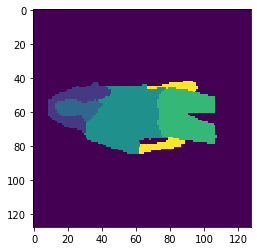

In [5]:
print(images[0].shape)
_=plt.imshow(segmentations[i][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3)


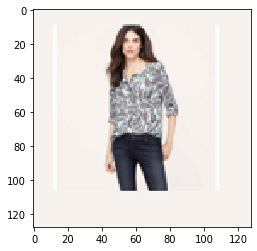

In [6]:
print(images[90].T.shape)
_=plt.imshow(images[i].T + image_mean.T)

### Forming train, test splits

We will extract the images out from the h5 dataformat into a list of chunks.

In [7]:
images, segmentations = shuffle(images[()], segmentations[()])

In [8]:
train_images, test_images, train_segmentations, test_segmentations = train_test_split(
    images, segmentations, test_size=TEST_RATIO, shuffle=False)
train_images, val_images, train_segmentations, val_segmentations = train_test_split(
    train_images, train_segmentations, test_size=TEST_RATIO, shuffle=False)
images = {'train': train_images, 'val': val_images, 'test': test_images}
segmentations = {'train': train_segmentations, 'val': val_segmentations, 'test': test_segmentations}

In [9]:
img_chunks = {}
seg_chunks = {}
for split in ['train', 'val', 'test']:
    img_chunks[split] = []
    seg_chunks[split] = []
    for i in range(math.floor(len(images[split]) // IMG_PER_CHUNK)):
        img_chunks[split].append(images[split][i*IMG_PER_CHUNK: (i+1) * IMG_PER_CHUNK])
        seg_chunks[split].append(segmentations[split][i*IMG_PER_CHUNK: (i+1) * IMG_PER_CHUNK])
    img_chunks[split].append(images[split][(math.floor(len(images[split])//IMG_PER_CHUNK)) * IMG_PER_CHUNK:])
    seg_chunks[split].append(segmentations[split][(math.floor(len(segmentations[split])//IMG_PER_CHUNK))
                                                  * IMG_PER_CHUNK:])

In [10]:
print('{} train chunks.'.format(len(img_chunks['train'])))
print('{} val chunks.'.format(len(img_chunks['val'])))
print('{} test chunks.'.format(len(img_chunks['test'])))
print('Total of {} chunks.'.format(len(img_chunks['train']) + len(img_chunks['val']) 
                                   + len(img_chunks['test'])))


33 train chunks.
9 val chunks.
11 test chunks.
Total of 53 chunks.


The shuffle method creates a copy, so we can delete the images and segmentations to make room in RAM.

In [11]:
del images, segmentations
gc.collect()

2466

### Serializing to Tensorflow examples

Our images are sized the same and we will be exploring unconditional training so we can set our shape and label as constants.

In [12]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[*value]))

def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [13]:
def encode_image(image):
    out = tf.image.convert_image_dtype(image, dtype=tf.uint8).numpy().T
    return out.tostring()

In [14]:
def serialize_example(img, seg=None):
    '''
    Creates a tf.Example message ready to be written to a file.
    '''
    # Encode the image
    img = encode_image(img)
    seg = encode_image(seg)

    # Create a dictionary mapping the feature name to the tf.Example-compatible data type.
    feature = {
        'image': _bytes_feature(img),
        'segmentation': _bytes_feature(seg)
    } 
    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [15]:
def parse_tfrecord_tf(record, res=128):
    look_for = {
        'image': tf.FixedLenFeature([], tf.string),
        'segmentation': tf.FixedLenFeature([], tf.string)
    }
    features = tf.parse_single_example(record, features=look_for)
    # to get CelebA attr, add 'attr': tf.FixedLenFeature([40], tf.int64)
    image, segmentation = features['image'], features['segmentation']
    image = tf.decode_raw(image, tf.uint8)
    image = tf.reshape(image, [res, res, 3])
    segmentation = tf.decode_raw(segmentation, tf.uint8)
    segmentation = tf.reshape(segmentation, [res, res])
    return image, segmentation  

This is all the massaging needed to get our serialized example, let's give it a try with a sample image and segmentation map.

In [16]:
i = 101
sample_img = train_images[i]
sample_seg = train_segmentations[i]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


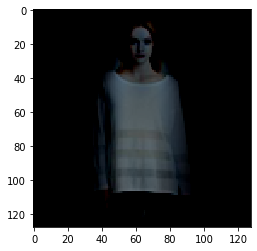

In [17]:
plt.imshow(sample_img.T)

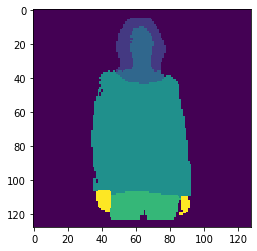

In [18]:
plt.imshow(sample_seg.T[:,:,0])

In [19]:
sample_serialized = serialize_example(sample_img, sample_seg)
print('sample_serialized: {}...'.format(sample_serialized[:100]))

sample_serialized: b'\n\xb5\x80\x04\n\x9a\x80\x01\n\x0csegmentation\x12\x88\x80\x01\n\x84\x80\x01\n\x80\x80\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'...


Let's see if everything is working by parsing the serialized example.

In [20]:
img, seg = parse_tfrecord_tf(sample_serialized, res=128)

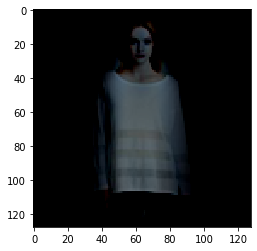

In [21]:
plt.imshow(img)

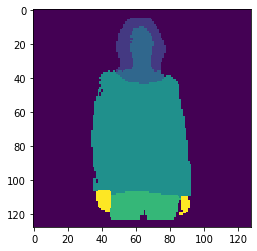

In [22]:
plt.imshow(seg)

### Exporting tfrecords 

Filename format will be:
```
{split}-res{:02, log2(resolution)}-{:02, chunk}-of-{:02, num_chunks}.tfrecords
```

In [32]:
TFRECORD_DIR = os.path.join(DEEPFASHION_DIR, 'Fashion Synthesis', 'tfrecords')
EXPORT_DIR = {split: os.path.join(TFRECORD_DIR, split) for split in ['train', 'val', 'test']}

In [34]:
def get_filename(split, chunk, num_chunks, res):
    return '{}-res{:02}-{:02}-of-{:02}.tfrecords'.format(split, int(np.log2(res)), chunk, num_chunks)

In [35]:
def save_records(records, split, chunk, num_chunks, res=128):
    path = os.path.join(EXPORT_DIR[split], get_filename(split, chunk, num_chunks, res))
    with tf.python_io.TFRecordWriter(path) as writer:
        for record in records:
            writer.write(record)

In [37]:
for split in ['train', 'val', 'test']:
    for chunk in tqdm(range(len(img_chunks[split]))):
        records = [serialize_example(img_chunks[split][chunk][i], seg_chunks[split][chunk][i]) 
                   for i in range(len(img_chunks[split][chunk]))]
        save_records(records, split, chunk+1, len(img_chunks[split]))